In [ ]:
#Title

In [ ]:
#description

In [65]:
#imports
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# List of Aristotle Works: https://classics.mit.edu/Browse/browse-Aristotle.html
# Categories (81k)
# On Dreams (23k)
# On the Gait of Animals (43k)
# On Generation and Corruption (152k)
# On the Heavens (221k)
# On Longevity and the Shortness of Life (14k)
# On Memory and Reminiscence (27k)
# Metaphysics (604k)
# Nichomachean Ethics (456k)
# Physics (455k)
# Politics Book I (70k)
# Posterior Analytics (189k)
# Prior Analytics (255k)
# Rhetoric (373k)
# On The Soul (176k)
# Topics (384k)

# Reading in the Aristotle txt file
with open('aristotle_texts.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(text[:1000])

SECTION 1

Part 1 

Things are said to be named 'equivocally' when, though they have
a common name, the definition corresponding with the name differs
for each. Thus, a real man and a figure in a picture can both lay
claim to the name 'animal'; yet these are equivocally so named, for,
though they have a common name, the definition corresponding with
the name differs for each. For should any one define in what sense
each is an animal, his definition in the one case will be appropriate
to that case only. 

On the other hand, things are said to be named 'univocally' which
have both the name and the definition answering to the name in common.
A man and an ox are both 'animal', and these are univocally so named,
inasmuch as not only the name, but also the definition, is the same
in both cases: for if a man should state in what sense each is an
animal, the statement in the one case would be identical with that
in the other. 

Things are said to be named 'derivatively', which derive their nam

In [4]:
# Determining the number of unique characters in the text 
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"&'()+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz|
82


In [7]:
# POSSIBLE ADDITION - USING SENTENCEPIECE OR TIKTOKEN for tokenization

# create a mapping from characters to integers (trivial tokenization)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("wassup bro"))
print(decode(encode("wassup bro")))

[77, 55, 73, 73, 75, 70, 1, 56, 72, 69]
wassup bro


In [10]:
# Encoding entire text into torch tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([3185699]) torch.int64
tensor([45, 31, 29, 46, 35, 41, 40,  1, 14,  0,  0, 42, 55, 72, 74,  1, 14,  1,
         0,  0, 46, 62, 63, 68, 61, 73,  1, 55, 72, 59,  1, 73, 55, 63, 58,  1,
        74, 69,  1, 56, 59,  1, 68, 55, 67, 59, 58,  1,  5, 59, 71, 75, 63, 76,
        69, 57, 55, 66, 66, 79,  5,  1, 77, 62, 59, 68,  9,  1, 74, 62, 69, 75,
        61, 62,  1, 74, 62, 59, 79,  1, 62, 55, 76, 59,  0, 55,  1, 57, 69, 67,
        67, 69, 68,  1, 68, 55, 67, 59,  9,  1])


In [11]:
# Splitting data into train and validation
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [56]:
context_window = 8
print(train_data[:context_window+1])

# Visualizing how text is split into different lengths, up to context size
x = train_data[:context_window]
y = train_data[1:context_window+1]
for t in range(context_window):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

tensor([45, 31, 29, 46, 35, 41, 40,  1, 14])
when input is tensor([45]) the target: 31
when input is tensor([45, 31]) the target: 29
when input is tensor([45, 31, 29]) the target: 46
when input is tensor([45, 31, 29, 46]) the target: 35
when input is tensor([45, 31, 29, 46, 35]) the target: 41
when input is tensor([45, 31, 29, 46, 35, 41]) the target: 40
when input is tensor([45, 31, 29, 46, 35, 41, 40]) the target: 1
when input is tensor([45, 31, 29, 46, 35, 41, 40,  1]) the target: 14


In [57]:
torch.manual_seed(42)
batch_size = 4 # how many independent sequences will we process in parallel?
context_window = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window, (batch_size,))
    x = torch.stack([data[i:i+context_window] for i in ix])
    y = torch.stack([data[i+1:i+context_window+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(context_window): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[77, 62, 55, 74,  9,  1, 69, 74],
        [59, 68, 74, 24,  1, 55, 68, 58],
        [73,  9,  1, 56, 75, 74,  0, 74],
        [63, 57, 55, 56, 66, 59,  1, 69]])
targets:
torch.Size([4, 8])
tensor([[62, 55, 74,  9,  1, 69, 74, 62],
        [68, 74, 24,  1, 55, 68, 58,  0],
        [ 9,  1, 56, 75, 74,  0, 74, 62],
        [57, 55, 56, 66, 59,  1, 69, 60]])
----
when input is [77] the target: 62
when input is [77, 62] the target: 55
when input is [77, 62, 55] the target: 74
when input is [77, 62, 55, 74] the target: 9
when input is [77, 62, 55, 74, 9] the target: 1
when input is [77, 62, 55, 74, 9, 1] the target: 69
when input is [77, 62, 55, 74, 9, 1, 69] the target: 74
when input is [77, 62, 55, 74, 9, 1, 69, 74] the target: 62
when input is [59] the target: 68
when input is [59, 68] the target: 74
when input is [59, 68, 74] the target: 24
when input is [59, 68, 74, 24] the target: 1
when input is [59, 68, 74, 24, 1] the target: 55
when input is [59, 

### Bigram Language Model

In [71]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(42)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
logits, loss = model(xb, yb)
print(logits.shape)
print(loss)

print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([256, 82])
tensor(4.9494, grad_fn=<NllLossBackward0>)

IJ'idsojTids(C
4[a7P5T;t.aZesO:5El?yfr;"ID C,)0bJk/u52m3j![a0:kAl?h?]V:fm1luBmgrOc70,8D(n&-1(r;za&&V


In [47]:
# Testing

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.361097812652588


In [72]:
eval_iters = 200
max_iters = 10000
eval_interval = 500
batch_size = 32

def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

step 0: train loss 4.9093, val loss 4.8975
step 500: train loss 4.2835, val loss 4.2875
step 1000: train loss 3.7799, val loss 3.7985
step 1500: train loss 3.3966, val loss 3.4138
step 2000: train loss 3.1004, val loss 3.1337
step 2500: train loss 2.8883, val loss 2.9324
step 3000: train loss 2.7448, val loss 2.7778
step 3500: train loss 2.6270, val loss 2.6856
step 4000: train loss 2.5492, val loss 2.6070
step 4500: train loss 2.5019, val loss 2.5533
step 5000: train loss 2.4689, val loss 2.5149
step 5500: train loss 2.4352, val loss 2.4999
step 6000: train loss 2.4186, val loss 2.4703
step 6500: train loss 2.4092, val loss 2.4700
step 7000: train loss 2.3994, val loss 2.4551
step 7500: train loss 2.3921, val loss 2.4466
step 8000: train loss 2.3893, val loss 2.4392
step 8500: train loss 2.3757, val loss 2.4380
step 9000: train loss 2.3727, val loss 2.4338
step 9500: train loss 2.3731, val loss 2.4313


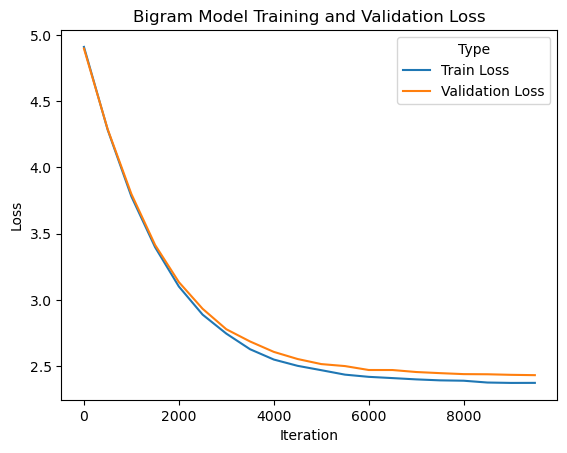



terese foss ed
site ars thitheroranthelperanem

o, isefised, th imomompls y sledenowigaly w an be tin pr thanissez. clexichincaron as
of pe an, llacofo nothRbe bltsalit isureattho-ee by?) me peture
evere pulyth t t twie nfothixtsl, (4key
I
po co be aytonaglashequg tal tty alls, phecatherecth thenuret
ueld (Thingutont.
ary torser be s ishovef if usl incts tey beang.ghe sd bl ciernmpper
og on abed t tus) alerthalan ar, armownt to wessesive iby the tompare asedis go B. cle d d civis;
Th uon, nnand


In [73]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Initialize lists to store iteration numbers and losses
iters, train_losses, val_losses = [], [], []

for iter in range(max_iters):
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
        # Append the current iteration and losses to the lists
        iters.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Convert lists that may contain tensors to numpy arrays
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# If you originally had tensors in the list, ensure they're converted to numpy arrays or Python scalars
train_losses = [loss.item() if hasattr(loss, 'item') else loss for loss in train_losses]
val_losses = [loss.item() if hasattr(loss, 'item') else loss for loss in val_losses]

# Create a DataFrame
df_losses = pd.DataFrame({'Iteration': iters, 'Train Loss': train_losses, 'Validation Loss': val_losses})

# Melt the DataFrame to plot with seaborn lineplot
df_melted = df_losses.melt('Iteration', var_name='Type', value_name='Loss')

# Plotting
sns.lineplot(data=df_melted, x='Iteration', y='Loss', hue='Type')
plt.title('Bigram Model Training and Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()  

    
context = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

### Math of Self-Attention

In [75]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [78]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)
        
# version 2: using matrix multiply for a weighted aggregation (getting average or previous timestep indexes)
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

# Can do weighted aggregation (avg) of past elements by using triangular matrix multiplication tricks.


True

In [79]:
# Q: What am I looking for
# K: What do I contain
# V: If you find me interesting, this is what I would communicate to you
# Q,K,V matrix is learned - generated for each token input

# Possible manipulation: Just give raw value x instead of linear layer v

"""KEY INSIGHT: Instead of initializing wei with all zeros 
(equal attention to all prev tokens after softmax)
we use Q, K, V to determine weights for wei before softmax 
"""

# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 # head size is output size of Q,K,V
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

# Need to add scaling to control variance at initialization, otherwise softmax will get to 'peaky' and try to converge to largest value in a one-hot manner


torch.Size([4, 8, 16])

In [ ]:
# Multiheaded attention: multiple single heads concatenated
# Similar to doing convolution in groups
# IDEA: Single head vs multihead attention


In [ ]:
# Add residual connections

In [80]:
# Add layer norms (normalizes the rows)
class LayerNorm1d: # (used to be BatchNorm1d)

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

# Implement layer norm before layer (pre-norm), which is different from the original paper

torch.Size([32, 100])

In [ ]:
# Add dropout (at end of residual pathway, end of MHA, and after softmax in forward in self attention head layer)
# reduce overfitting


Run on RunPod PyTorch 2.1, 1xA100 80GB cluster w/ 80GB VRAM and 117 GB RAM, 12 vCPU ($1.89 / hr). Took 2 hours and 44 minutes. 

## 10.8M model
#### hyperparameters
batch_size = 128 # how many independent sequences will we process in parallel?  
block_size = 256 # what is the maximum context length for predictions?  
max_iters = 2000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 # Size of embedding for tokens (input size to linear layers)  
n_head = 6 # number of heads in multi-headed attention  
n_layer = 6 # number of decoder blocks stacked in network  
dropout = 0.2  

Output:   
10.802002 M parameters
step 0: train loss 4.3749, val loss 4.3671

EMHaea9R&&.SE:GYL[)FDkCk|5aX77WkW1s!'HAENYb3iZ9Q+a,1G+ZaA+TY=7:DB.gtWVXQxngDQ!B]"!n0i2 TNN"8No:864RY  
step 500: train loss 1.3870, val loss 1.3879

'''''' by'' exqued'', thhen' in it, oneral'.
Aganny them?g. first add in therefinition
the two sency  
step 1000: train loss 1.1152, val loss 1.1395

exist, inhers we are train claise.

Thus, whether wark as it is true, and that are inquality, we hal
step 1500: train loss 1.0210, val loss 1.0731  

thing to this important something seems to be the differentiated by
the things both else] and in to 
step 1999: train loss 0.9693, val loss 1.0364  

woth; indeed similarly sense them are also known and the same kind
which means underlying the same, 

wether, or that which is scientific is either additing an attributable
or at a universal series a, or in the units, since I mean a pre-less
quantity resulting. For, that we have spatial: further, he does
not exist present only what is being or badlely, but also why the termined
could not. This will not exist also less, unless limit ought. 

When then the same is an instances of necessitate, while in the case
being not-will cannot be a capable of like quantity, and come. For then
it is capable of


## 14.3M model
#### hyperparameters
batch_size = 256 # how many independent sequences will we process in parallel?  
block_size = 256 # what is the maximum context length for predictions? 
max_iters = 10000  
eval_interval = 500  
learning_rate = 3e-4  
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
eval_iters = 200  
n_embd = 384 # Size of embedding for tokens (input size to linear layers)  
n_head = 8 # number of heads in multi-headed attention  
n_layer = 8 # number of decoder blocks stacked in network  
dropout = 0.2  <br>

Output <br>:  
step 0: train loss 4.4358, val loss 4.4354

O ];yrD]WL3UFx;H7QR:BXDx6m2eEO3,0IsnJ|UuP6"X(uq'2 (ZfU19cw"3|,(8ow6?5rTS|aKFn'"b(pmITxMTLM|kd2 s=Y3O


step 200: train loss 2.2986, val loss 2.3150

B tany ati) ' ined theree ovif con idestton oplly, 'ssthitrem; buro t ledisede maf tar ' at plecapol


step 400: train loss 1.4703, val loss 1.4708

the scepesses to not, impers of the bond mone on elurst. Yould might leto, then, isinams of one
we k


step 600: train loss 1.2005, val loss 1.2097

and wight, if is a matter from itsel= are present, and consequently
(3) and that which is they numbe


step 800: train loss 1.0938, val loss 1.1220

Epwardly. The tpeople proably hapbe in ricles
to be the definition of lipse, supposit we dill
with o


step 1000: train loss 1.0361, val loss 1.0816


""(Or obtail is so, were altered with these. Sometions too 'the stars',
but which they show they ma


step 1200: train loss 0.9978, val loss 1.0523

something heads only: It is said; (b) a
man what begans (ii) he will be think by setter. But, in ano


step 1400: train loss 0.9583, val loss 1.0256

less can be potentially, while something else it must. But
any other partness in argument in really 


step 1600: train loss 0.9338, val loss 1.0151

seful of seeing that is not the absence of thing); for if a matter
could be motion from one may be t


step 1800: train loss 0.9049, val loss 0.9937

are not more identical, or beyond the same thing. Again, if nothing
as moveer by itself but the move


step 2000: train loss 0.8862, val loss 0.9900

He has are taken absurd to subject, a number in which he marks
a circle or a simple wholly once. For


step 2200: train loss 0.8570, val loss 0.9671

will belong to the fact that are flesh to the science of all
the causes, yet in the same way. That w


step 2400: train loss 0.8350, val loss 0.9602

'poletical' leadinness against give relative step, in
another, thoughs they aime at "at the hand'. I


step 2600: train loss 0.8184, val loss 0.9538

the things itself are obsercts, and are not obviously conscious'
for all having their forms of leave


step 2800: train loss 0.8025, val loss 0.9550

is in time: so in the way that it is not possible for a thing
in the wholesol, and changes. And, som


step 3000: train loss 0.7886, val loss 0.9537

for his faculty with the sight of hnorator man. But we must
take their discovery arguments apart fro


step 3200: train loss 0.7693, val loss 0.9468

in what lies causes suffering, and gain water in flesh in Athenias the family
of touce hunds: for th


step 3400: train loss 0.7539, val loss 0.9488

It clearly then that
in no paositic syllogism that when one or not the other, and that
A belongs to 


step 3600: train loss 0.7395, val loss 0.9466

the reverse has been, so that if there is an infinity; nothing which
has parts of the power of cause


step 3800: train loss 0.7224, val loss 0.9475

Since white produces no white and black, is ultimate thing to be
the thine and the incontinent. Ther


step 4000: train loss 0.7098, val loss 0.9474

substance that has matter, in a sense the other category or substance
for another, but it is hether 


step 4200: train loss 0.6957, val loss 0.9497


"Oresons, there are some who make regular our power on people
do not in advocate increasing itsimpl


step 4400: train loss 0.6835, val loss 0.9562

means only what will happen, as we are said, considering self,
with hot and cold, or moists, are, wh


step 4600: train loss 0.6688, val loss 0.9595

the things of a siolong seem, and in nature to generates? Surely,
for a brazen specific death is the


step 4800: train loss 0.6539, val loss 0.9595

action. And now (b) the incontinent man is being productive in matter,
but no name is qualification 


step 5000: train loss 0.6449, val loss 0.9630

that is to which something else direction will be generated. Further,
in either of the whole is some


step 5200: train loss 0.6294, val loss 0.9700

from which we reduced? Again, as has been mentioned, one musician,
it is mind-this problem follows, 


step 5400: train loss 0.6205, val loss 0.9760

coming arise at a line which by nature, or line, or in point; for
it is a line, and if it is not pos


step 5600: train loss 0.6049, val loss 0.9778

elementary way should be knowingly-two: but without qualification,
necessarily view there is knowled


step 5800: train loss 0.5935, val loss 0.9824

theme voluntary; since the lower enjoyment is bad, yet, if from he
handed both their production he w


step 6000: train loss 0.5833, val loss 0.9956

leading to your reasoning that to be moved by something else, but
to those that they do do so. Howev


step 6200: train loss 0.5708, val loss 0.9953

is an action; but no man does anything accidentally by 'not being
a but 'being a man' or 'not-being 


step 6400: train loss 0.5598, val loss 1.0029

for dangers against the law that wherever' is voluntary, whereas
young people do not really wivole u


step 6600: train loss 0.5469, val loss 1.0128

for one class, the den air, and the dense of wood and everything else
and contrary. It is clear how 


step 6800: train loss 0.5359, val loss 1.0135

of seeing, we plain that it is needed not to both; for we make it
in the case of unequals whether so


step 7000: train loss 0.5277, val loss 1.0237

that movement is the series of the terms, which is equally of a straight
line certainly does not alw


step 7200: train loss 0.5172, val loss 1.0260

at the same time both because they cannot believe, indeed, but in
every case they enjoy; for things 


step 7400: train loss 0.5044, val loss 1.0314

them must be the same for demonstration. If, on the other hand, the
negative conclusion does not dep


step 7600: train loss 0.4975, val loss 1.0417

of their existence before every movement in so far as it is according
to the soul by some movement, 


step 7800: train loss 0.4865, val loss 1.0513

The universal last is universal: after the negative demonstration
is possible, the affirmative or th


step 8000: train loss 0.4740, val loss 1.0508

of things combined with the precision like themselves, as 'the prime
end' of our body is taken from 


step 8200: train loss 0.4653, val loss 1.0637

contrary to the other types: this is, for example and the contraries
above writers. But perhaps thos


step 8400: train loss 0.4578, val loss 1.0715

some time B may be left as one described from A. Suppose that A and
B belong to all the original B s


step 8600: train loss 0.4484, val loss 1.0783

very more uable and are always alike the same. But, as from an animal
is not a hand, so there is no 


step 8800: train loss 0.4401, val loss 1.0783

proves the point. Now these cannot be the source of animate not continuous
extent from also-animal f


step 9000: train loss 0.4322, val loss 1.0916

man would rold on friend omney or the other, the hindrance of the
disposition of the state. And ther


step 9200: train loss 0.4236, val loss 1.1002

paractical wisdom; nor can all Medea the house. For he that of a
cilas. Even the answer that a sign 


step 9400: train loss 0.4143, val loss 1.1076

seems to be that of the body which is due to the character of the
force. And it is these functions t


step 9600: train loss 0.4087, val loss 1.1090

obtains, on that ground the fact that, appetite is the thing to which
the virtue and will depart mov


step 9800: train loss 0.4035, val loss 1.1234

gather, psie, according to the matterials of certain speeches. We can
now turn out that no sensible 


step 9999: train loss 0.3922, val loss 1.1283

lack of being and being, and theoretical sciences use the same as
familiar or discriminating and tho



so though that things out of the same results a difference.

(1) Between animals makes things past exist in sensible things, that
we are seeking do them: an existence of things is sometime. Thus Just
as to say the strength is a cube, is nearly substance that first sometimes
not substance, when a separable thing is fixed by pleasure, but not
by further-we must not say that suming all things that we do not necessaryly
find everything that wants more permanent to a less. The first cause
of the good
